In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf 

In [85]:
# Read the csv file and clean the data
stock_data = pd.read_csv('dataCleaning/data.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
price_columns = ['Close/Last', 'Open', 'High', 'Low']
for column in price_columns:
    stock_data[column] = stock_data[column].str.replace('$', '').astype(float)
nflx_data = stock_data[stock_data['Company'] == 'NFLX']
nflx_data = nflx_data.sort_values(by="Date")
nflx_data.head()

C:\Users\Kha Nguyen\AppData\Local\Temp\ipykernel_11616\1220312108.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data[column] = stock_data[column].str.replace('$', '').astype(float)


,Company,Date,Close/Last,Volume,Open,High,Low
25159,NFLX,2013-07-18,38.0586,20418642,38.6157,38.6157,37.7143
25158,NFLX,2013-07-19,37.7966,18098750,38.2043,38.2784,37.5971
25157,NFLX,2013-07-22,37.4228,44791095,38.1214,38.3928,36.7314
25156,NFLX,2013-07-23,35.7514,76792963,35.9143,37.4621,35.1714
25155,NFLX,2013-07-24,34.4714,33395351,35.6743,36.0357,34.3143


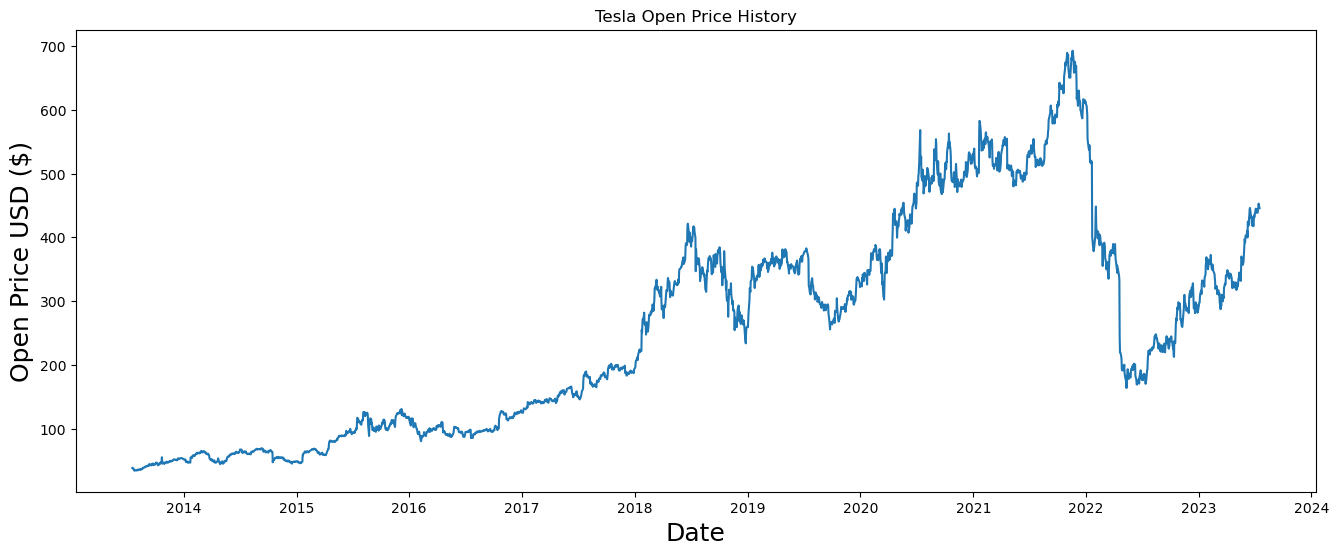

In [86]:
# Plotting the close price history
plt.figure(figsize=(16,6))
plt.title('Tesla Open Price History')
plt.plot(nflx_data['Date'], nflx_data['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

In [87]:
nflx_data.isna().any()

Company       False
Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

In [88]:
nflx_data.tail(10)

,Company,Date,Close/Last,Volume,Open,High,Low
22653,NFLX,2023-07-03,441.44,3728461,439.760,441.5450,431.6200
22652,NFLX,2023-07-05,445.90,6875414,444.910,450.9700,439.6244
22651,NFLX,2023-07-06,438.84,4944892,440.000,442.7999,430.7200
22650,NFLX,2023-07-07,438.10,4165144,438.600,442.3250,435.8354
22649,NFLX,2023-07-10,441.71,4251737,438.520,444.4100,436.8200
22648,NFLX,2023-07-11,440.21,4574559,438.650,440.8000,431.0415
22647,NFLX,2023-07-12,444.05,5731657,444.550,445.4085,437.7494
22646,NFLX,2023-07-13,450.38,6157475,447.000,451.6700,441.1770
22645,NFLX,2023-07-14,441.91,7195860,452.785,456.4800,439.7000
22644,NFLX,2023-07-17,450.05,6901141,445.570,456.6800,445.1053


In [89]:
nflx_data.describe()

,Close/Last,Volume,Open,High,Low
count,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000
mean,256.768639,1.123296e+07,256.724742,260.699942,252.602322
std,168.759861,1.011297e+07,168.855278,171.170811,166.331971
min,34.471400,1.143952e+06,34.365700,35.282800,34.272800
25%,97.905000,5.294856e+06,97.837500,99.582500,96.775000
50%,244.605000,8.364012e+06,244.745000,249.666050,237.120000
75%,366.905000,1.408236e+07,366.957500,371.612425,361.181250
max,691.690000,1.797491e+08,692.350000,700.989400,686.090000


In [90]:
nflx_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 25159 to 22644
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Company     2516 non-null   object        
 1   Date        2516 non-null   datetime64[ns]
 2   Close/Last  2516 non-null   float64       
 3   Volume      2516 non-null   int64         
 4   Open        2516 non-null   float64       
 5   High        2516 non-null   float64       
 6   Low         2516 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 157.2+ KB


In [91]:
nflx_data.isnull().sum()

Company       0
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [92]:
# Split training and testing datasets

df_test = nflx_data.tail(40)
nflx_df = nflx_data.iloc[::-1]

In [93]:
nflx_df['Open'].mean()

256.72474205087394

c:\Users\Kha Nguyen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Kha Nguyen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Kha Nguyen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

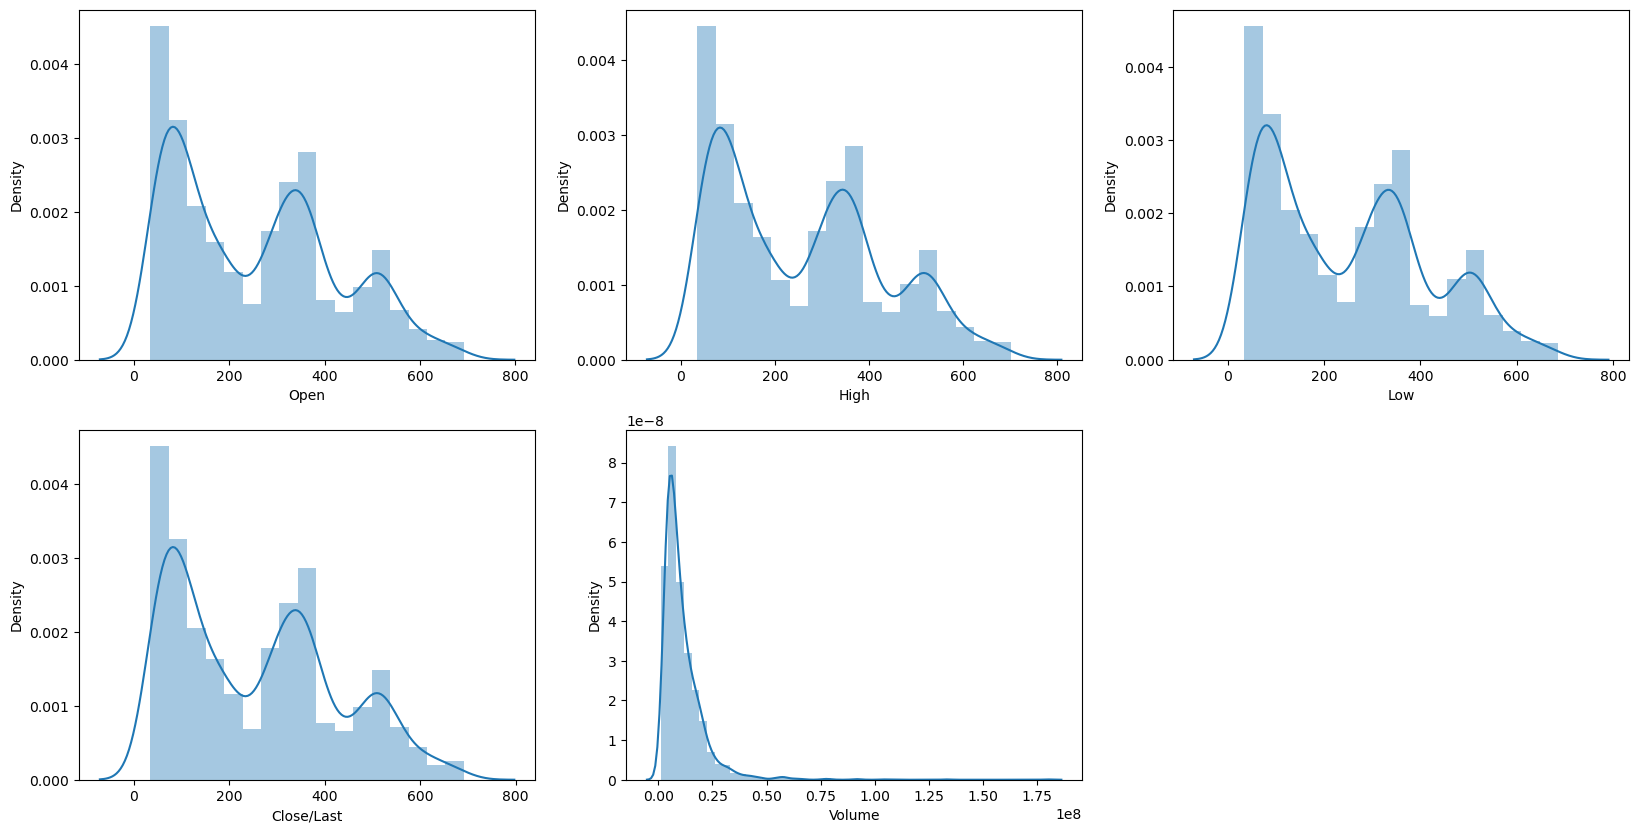

In [94]:
import seaborn as sb
features = ['Open', 'High', 'Low', 'Close/Last', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(nflx_data[col])
plt.show()

In [95]:
nflx_data.describe()

,Close/Last,Volume,Open,High,Low
count,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000
mean,256.768639,1.123296e+07,256.724742,260.699942,252.602322
std,168.759861,1.011297e+07,168.855278,171.170811,166.331971
min,34.471400,1.143952e+06,34.365700,35.282800,34.272800
25%,97.905000,5.294856e+06,97.837500,99.582500,96.775000
50%,244.605000,8.364012e+06,244.745000,249.666050,237.120000
75%,366.905000,1.408236e+07,366.957500,371.612425,361.181250
max,691.690000,1.797491e+08,692.350000,700.989400,686.090000


In [96]:
nflx_data

,Company,Date,Close/Last,Volume,Open,High,Low
25159,NFLX,2013-07-18,38.0586,20418642,38.6157,38.6157,37.7143
25158,NFLX,2013-07-19,37.7966,18098750,38.2043,38.2784,37.5971
25157,NFLX,2013-07-22,37.4228,44791095,38.1214,38.3928,36.7314
25156,NFLX,2013-07-23,35.7514,76792963,35.9143,37.4621,35.1714
25155,NFLX,2013-07-24,34.4714,33395351,35.6743,36.0357,34.3143
...,...,...,...,...,...,...,...
22648,NFLX,2023-07-11,440.2100,4574559,438.6500,440.8000,431.0415
22647,NFLX,2023-07-12,444.0500,5731657,444.5500,445.4085,437.7494
22646,NFLX,2023-07-13,450.3800,6157475,447.0000,451.6700,441.1770
22645,NFLX,2023-07-14,441.9100,7195860,452.7850,456.4800,439.7000


c:\Users\Kha Nguyen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Kha Nguyen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Kha Nguyen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Kha Ngu

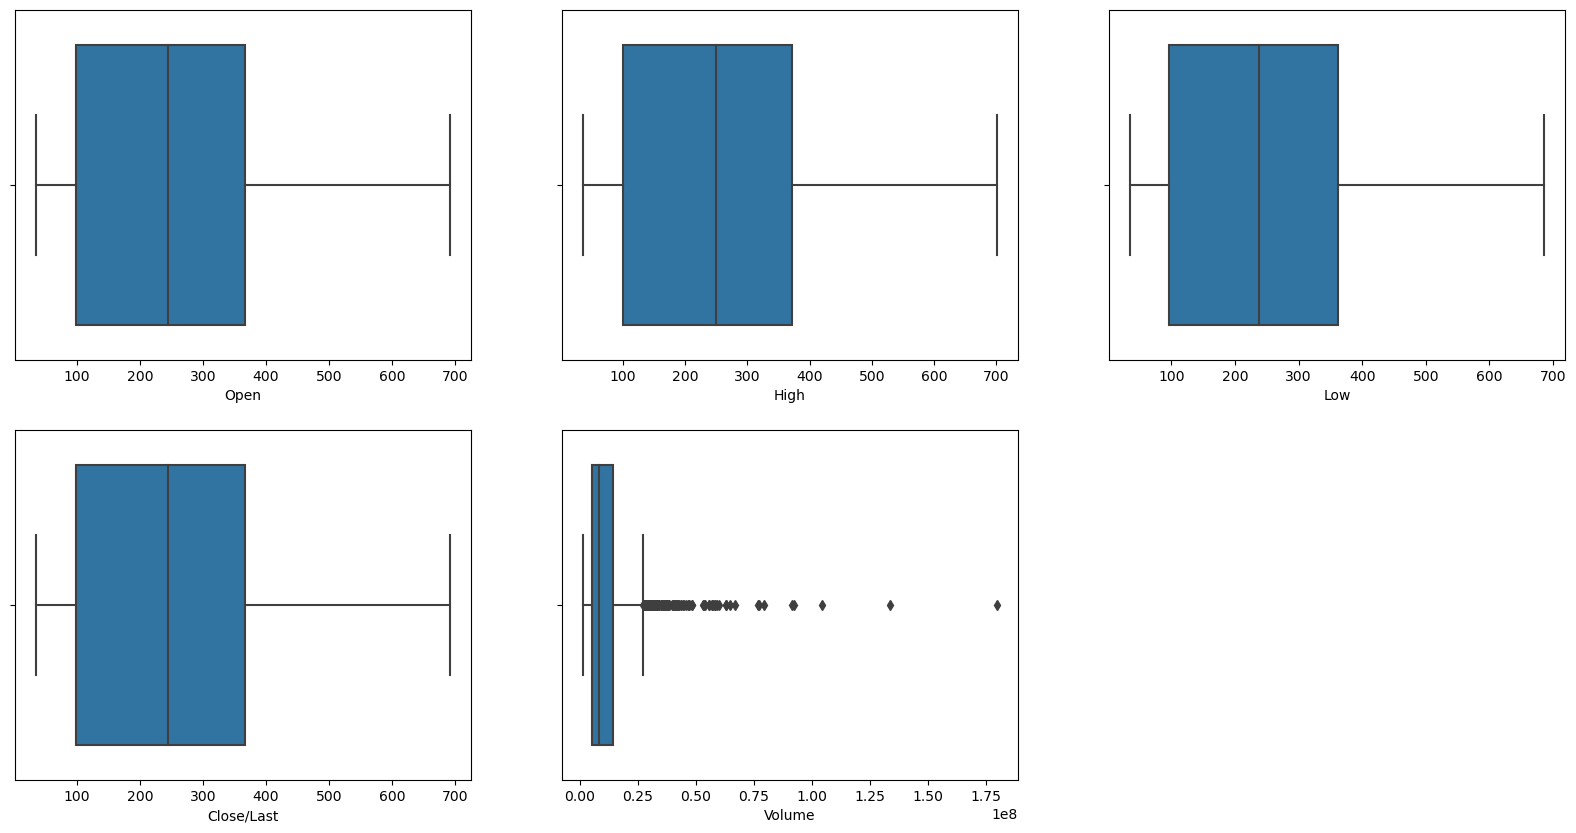

In [97]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(nflx_data[col])
plt.show()

In [98]:
nflx_data["Date"] = nflx_data["Date"].astype(str) 
splitted = nflx_data['Date'].str.split('-', expand=True)
 
nflx_data['day'] = splitted[2].astype('int')
nflx_data['month'] = splitted[1].astype('int')
nflx_data['year'] = splitted[0].astype('int')
 
nflx_data.head()

,Company,Date,Close/Last,Volume,Open,High,Low,day,month,year
25159,NFLX,2013-07-18,38.0586,20418642,38.6157,38.6157,37.7143,18,7,2013
25158,NFLX,2013-07-19,37.7966,18098750,38.2043,38.2784,37.5971,19,7,2013
25157,NFLX,2013-07-22,37.4228,44791095,38.1214,38.3928,36.7314,22,7,2013
25156,NFLX,2013-07-23,35.7514,76792963,35.9143,37.4621,35.1714,23,7,2013
25155,NFLX,2013-07-24,34.4714,33395351,35.6743,36.0357,34.3143,24,7,2013


In [99]:
nflx_data.tail(5)

,Company,Date,Close/Last,Volume,Open,High,Low,day,month,year
22648,NFLX,2023-07-11,440.21,4574559,438.650,440.8000,431.0415,11,7,2023
22647,NFLX,2023-07-12,444.05,5731657,444.550,445.4085,437.7494,12,7,2023
22646,NFLX,2023-07-13,450.38,6157475,447.000,451.6700,441.1770,13,7,2023
22645,NFLX,2023-07-14,441.91,7195860,452.785,456.4800,439.7000,14,7,2023
22644,NFLX,2023-07-17,450.05,6901141,445.570,456.6800,445.1053,17,7,2023


In [100]:
nflx_data.isnull().sum()

Company       0
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
day           0
month         0
year          0
dtype: int64

In [101]:
nflx_data['is_quarter_end'] = np.where(nflx_data['month']%3==0,1,0)
nflx_data.head()

,Company,Date,Close/Last,Volume,Open,High,Low,day,month,year,is_quarter_end
25159,NFLX,2013-07-18,38.0586,20418642,38.6157,38.6157,37.7143,18,7,2013,0
25158,NFLX,2013-07-19,37.7966,18098750,38.2043,38.2784,37.5971,19,7,2013,0
25157,NFLX,2013-07-22,37.4228,44791095,38.1214,38.3928,36.7314,22,7,2013,0
25156,NFLX,2013-07-23,35.7514,76792963,35.9143,37.4621,35.1714,23,7,2013,0
25155,NFLX,2013-07-24,34.4714,33395351,35.6743,36.0357,34.3143,24,7,2013,0


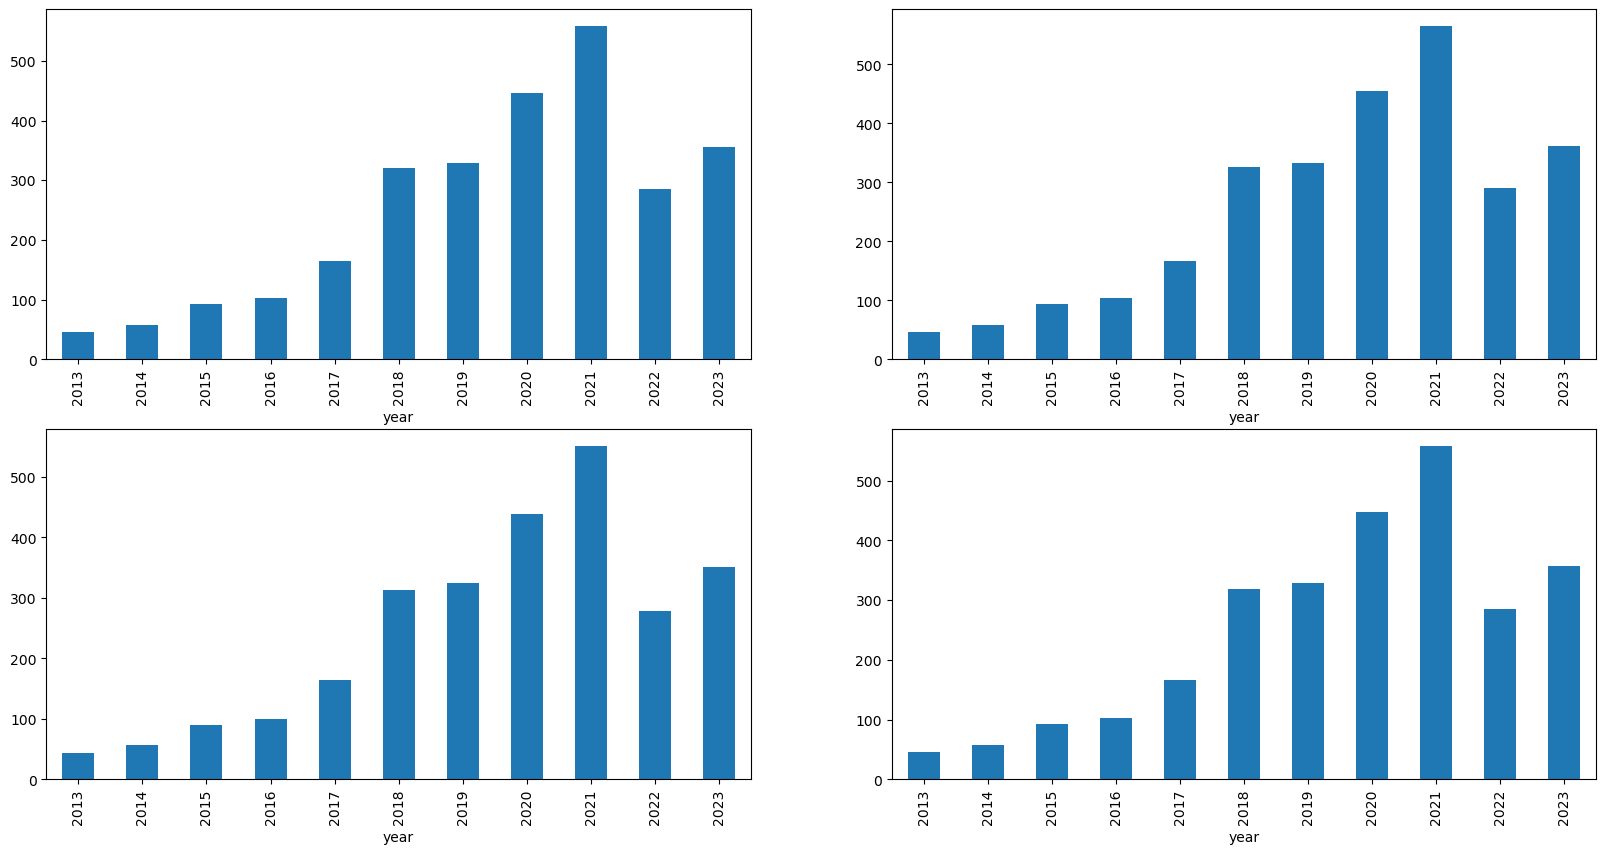

In [102]:
data_grouped = nflx_data.groupby('year').mean()
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close/Last']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [103]:
nflx_data.groupby('is_quarter_end').mean()

,Close/Last,Volume,Open,High,Low,day,month,year
is_quarter_end,,,,,,,,
0,256.356048,1.204594e+07,256.201283,260.194308,252.129439,15.730931,6.096697,2018.040841
1,257.575881,9.642351e+06,257.748900,261.689226,253.527529,15.772033,7.431257,2018.024677


In [104]:
nflx_data['open-close']  = nflx_data['Open'] - nflx_data['Close/Last']
nflx_data['low-high']  = nflx_data['Low'] - nflx_data['High']
nflx_data['target'] = np.where(nflx_data['Close/Last'].shift(-1) > nflx_data['Close/Last'], 1, 0)


In [105]:
plt.figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

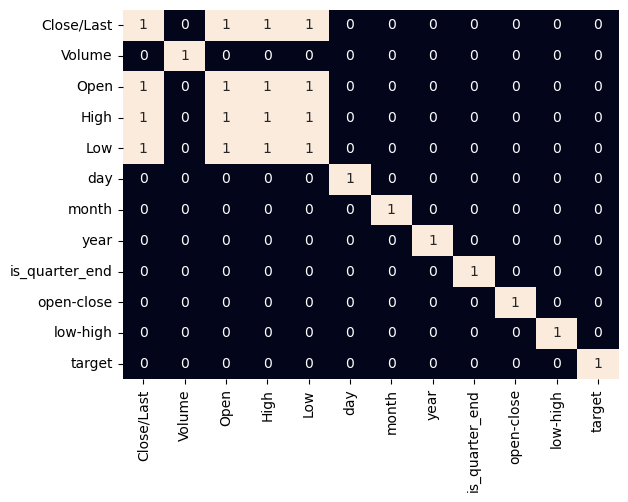

In [106]:
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(nflx_data.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
features = nflx_data[['open-close', 'low-high', 'is_quarter_end']]
target = nflx_data['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2264, 3) (252, 3)


In [108]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC

In [109]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
 
for i in range(3):
  models[i].fit(X_train, Y_train)
 
  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5336983575472309
Validation Accuracy :  0.518733809313199

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.5318466835824229
Validation Accuracy :  0.49804132179187466

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

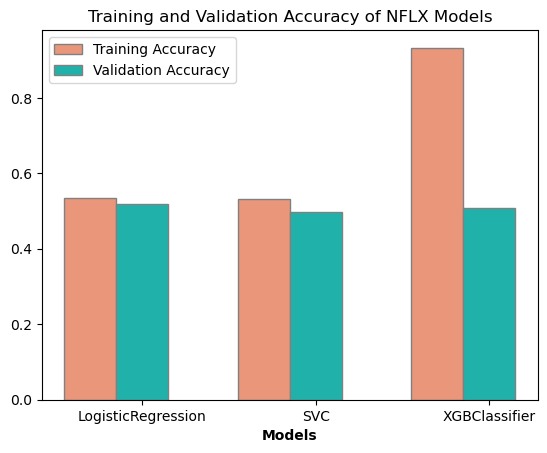

In [110]:
# Model names
models_name = ['LogisticRegression', 'SVC', 'XGBClassifier']

# Training accuracy values
train_acc = [0.5336983575472309, 0.5320801928677361, 0.9326997343929501]

# Validation accuracy values
val_acc = [0.518733809313199, 0.4982624628798888, 0.5071081064004549]

# Bar width
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(train_acc))
r2 = [x + barWidth for x in r1]

# Create blue bars for training accuracy
plt.bar(r1, train_acc, color='darksalmon', width=barWidth, edgecolor='grey', label='Training Accuracy')

# Create red bars for validation accuracy
plt.bar(r2, val_acc, color='lightseagreen', width=barWidth, edgecolor='grey', label='Validation Accuracy')

# Title & Subtitle
plt.title('Training and Validation Accuracy of NFLX Models')
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train_acc))], models_name)

# Create legend & Show graphic
plt.legend()
plt.savefig('NFLX_plot.png')

plt.show()